In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import scipy
import functools as ft
import random
from scipy.signal import savgol_filter as savitzky_golay
from qiskit.quantum_info import Operator

X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.identity(2)

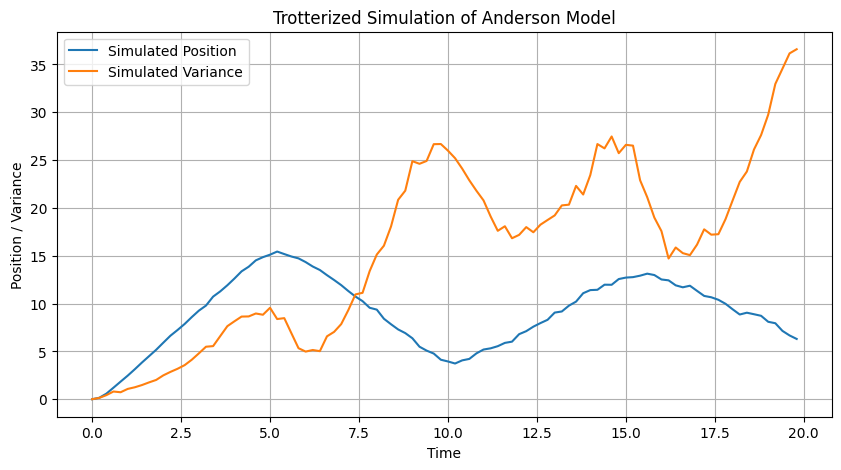

In [20]:
simulator = Aer.get_backend('aer_simulator')

def run_trotterized_simulation_qiskit_gates(steps, T, random_factor, num_qubits):
    r = np.arange(0, T, .2)
    b = [random.random()*random_factor for _ in range(num_qubits)]
    shots = 1000
    positions = []
    variances = []

    for t in r:
        circuit = QuantumCircuit(num_qubits)
        circuit.x(0)

        # One step of the Trotterization
        for i in range(steps):

            dt = t/steps
            # Adding gates in alternating fashion (maximizes parallelization)
            circuit.rxx(theta=2*dt, qubit1=(j for j in range(0, num_qubits-1, 2)), qubit2=(j+1 for j in range(0, num_qubits-1, 2)))
            circuit.rxx(theta=2*dt, qubit1=(j for j in range(1, num_qubits-1, 2)), qubit2=(j+1 for j in range(1, num_qubits-1, 2)))
            circuit.ryy(theta=2*dt, qubit1=(j for j in range(0, num_qubits-1, 2)), qubit2=(j+1 for j in range(0, num_qubits-1, 2)))
            circuit.ryy(theta=2*dt, qubit1=(j for j in range(1, num_qubits-1, 2)), qubit2=(j+1 for j in range(1, num_qubits-1, 2)))
            for j in range(num_qubits):
                circuit.rz(phi=b[j]*dt, qubit=j)
            

        circuit.measure_all()

        compiled_circuit = transpile(circuit, simulator)
        job = simulator.run(compiled_circuit, shots=shots)
        result = job.result()
        counts = dict(result.get_counts())

        avg_location = 0
        for bitstring, freq in sorted(counts.items(), key=lambda x: x[1], reverse=True):
            location = num_qubits-1-bitstring.index('1')
            avg_location += location * freq / shots

        variance = 0
        for bitstring, freq in sorted(counts.items(), key=lambda x: x[1], reverse=True):
            location = num_qubits-1-bitstring.index('1')
            variance += (location - avg_location) ** 2 * freq / shots

        positions.append(avg_location)
        variances.append(variance)
    
    return positions, variances

total_time = 20
simulated_positions, simulated_variances = run_trotterized_simulation_qiskit_gates(steps=100, T=total_time, random_factor=0, num_qubits=18)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, total_time, 0.2), simulated_positions, label='Simulated Position')
plt.plot(np.arange(0, total_time, 0.2), simulated_variances, label='Simulated Variance')
plt.xlabel('Time')
plt.ylabel('Position / Variance')
plt.title('Trotterized Simulation of Anderson Model')
plt.legend()
plt.grid()
plt.show()

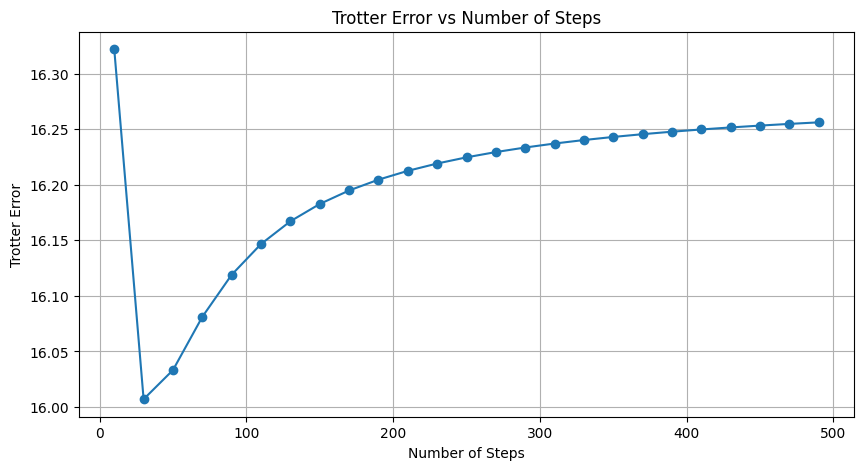

In [18]:
def get_gi(gate, i, n, get_gi1=False):
    gates = []
    for j in range(n):
        if j == i or (j == i+1 and get_gi1):
            gates.append(gate)
        else:
            gates.append(I)
    return ft.reduce(np.kron, gates)

# Creates a Hamiltonian for the Anderson model
def construct_hamiltonian(n):
    b = [1 for i in range(n)]
    b2 = [1 for i in range(n-1)]

    h1 = sum(b2[i]*(get_gi(X, i, n, True) + get_gi(Y, i, n, True)) for i in range(n-1))
    h2 = sum((b[i] * get_gi(Z, i, n)) for i in range(n))
    return h1 + h2

def u(t, H):
    return scipy.linalg.expm(-1j * H * t)

def calculate_trotter_error(num_qubits, max_steps):
    r = range(10, max_steps, 20)

    error_values = []

    for steps in r:
        ideal = u(10, construct_hamiltonian(num_qubits))

        dt = 10/steps
        circuit = QuantumCircuit(num_qubits)
        circuit.rxx(theta=2*dt, qubit1=(j for j in range(0, num_qubits-1, 2)), qubit2=(j+1 for j in range(0, num_qubits-1, 2)))
        circuit.rxx(theta=2*dt, qubit1=(j for j in range(1, num_qubits-1, 2)), qubit2=(j+1 for j in range(1, num_qubits-1, 2)))
        circuit.ryy(theta=2*dt, qubit1=(j for j in range(0, num_qubits-1, 2)), qubit2=(j+1 for j in range(0, num_qubits-1, 2)))
        circuit.ryy(theta=2*dt, qubit1=(j for j in range(1, num_qubits-1, 2)), qubit2=(j+1 for j in range(1, num_qubits-1, 2)))
        for j in range(num_qubits):
            circuit.rz(phi=dt, qubit=j)
        trotterized_matrix = Operator(circuit)

        error = scipy.linalg.norm(ideal - trotterized_matrix)
        error_values.append(error)

    return error_values

Max_Steps = 500
errors = calculate_trotter_error(7, Max_Steps)

plt.figure(figsize=(10, 5))
plt.plot(range(10, Max_Steps, 20), errors, marker='o')
plt.title('Trotter Error vs Number of Steps')
plt.xlabel('Number of Steps')
plt.ylabel('Trotter Error')
plt.grid()
plt.show()

**Some Notes**

Trotterization done by splitting hamiltonian into groups of $R_{xx}$, $R_{yy}$, and $R_{z}$ gates. All of the gates in these groups are all self commuting, so this arrangement minimizes trotter error. One trotter step of this trotterization looks like

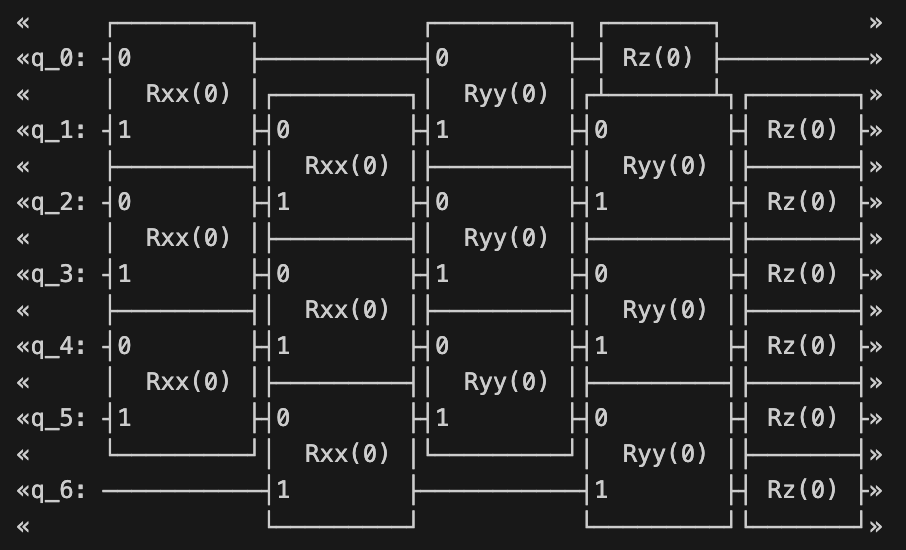.

A hundred of these trotter steps are used which has trotter error of about 16 in accordance to this strange graph???????????

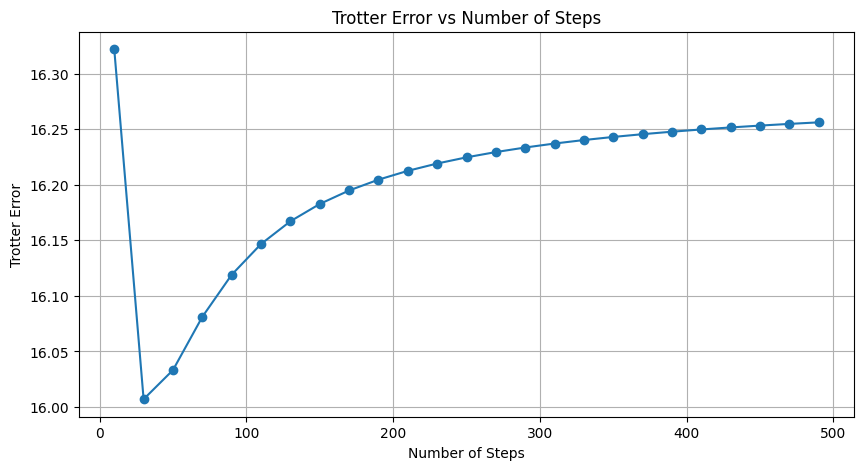

This error calculation is clearly incorrect when we compare the output simulations of a trotterized and non trotterized simulation